In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2


In [76]:
img = cv2.imread('dataset/images/1/1.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img_gray.shape)

(1080, 1920)


In [81]:
def plot_gray(img):
    assert len(img.shape) == 2
    plt.imshow(img, cmap='gray')
def plot_color(img, size=None):
    assert len(img.shape) == 3
    b,g,r = cv2.split(img)       # get b,g,r
    rgb = cv2.merge([r,g,b])     # switch it to rgb
    if size is not None:
        plt.figure(figsize=size)
    plt.imshow(rgb)

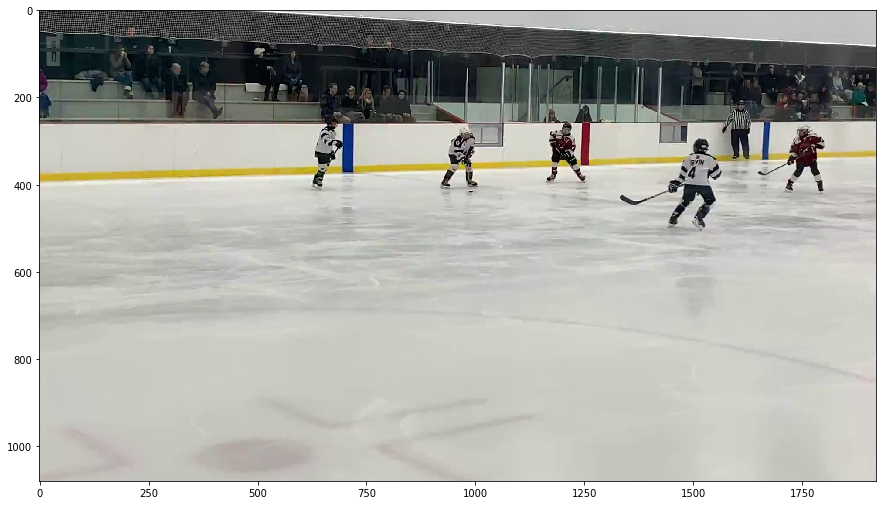

In [82]:
plot_color(img, (15,15) )

# Part 1: Rink detection

Pipeline: 
- p1: RGB -> Gray
- p2: Threshold
- p3: Gaussian Blur
- p4: Threshold
- p5: Convex Hull

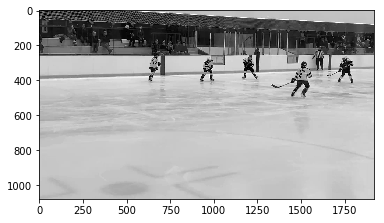

In [83]:
p1 = img_gray.copy()
plot_gray(p1)

In [84]:
def threshold_gray(img_gray, min_thresh, max_thresh):
    copy = img_gray.copy()
    copy[img_gray > max_thresh] = 0
    copy[img_gray < max_thresh] = 255
    copy[img_gray < min_thresh] = 0
    return copy

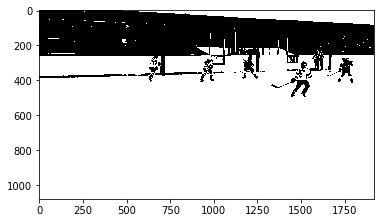

In [85]:
p2 = threshold_gray(p1, 143, 255)
plt.imshow(p2, cmap='gray')

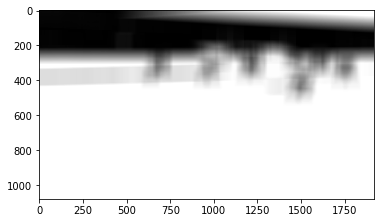

In [86]:
kernel_size = (97, 97)
p3 =cv2.blur(p2, kernel_size ,cv2.BORDER_DEFAULT)
plt.imshow(p3, cmap='gray')

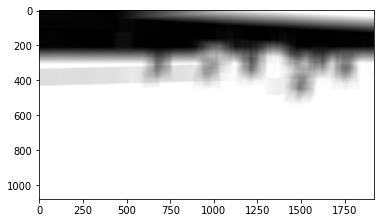

In [87]:
tmp = p3.copy()
for i in range(100):
    tmp =cv2.blur(p3, (5,5) ,cv2.BORDER_DEFAULT)
    plt.imshow(tmp, cmap='gray')

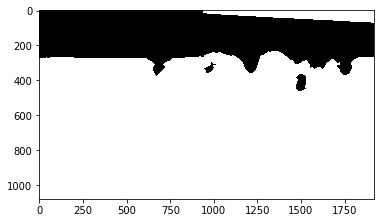

In [88]:
p4 = threshold_gray(p3, 157,255)
plot_gray(p4)

In [89]:
def convex_hull(img):
    contours, hierarchy = cv2.findContours(img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    hull = cv2.convexHull(max(contours, key = cv2.contourArea))
    return hull

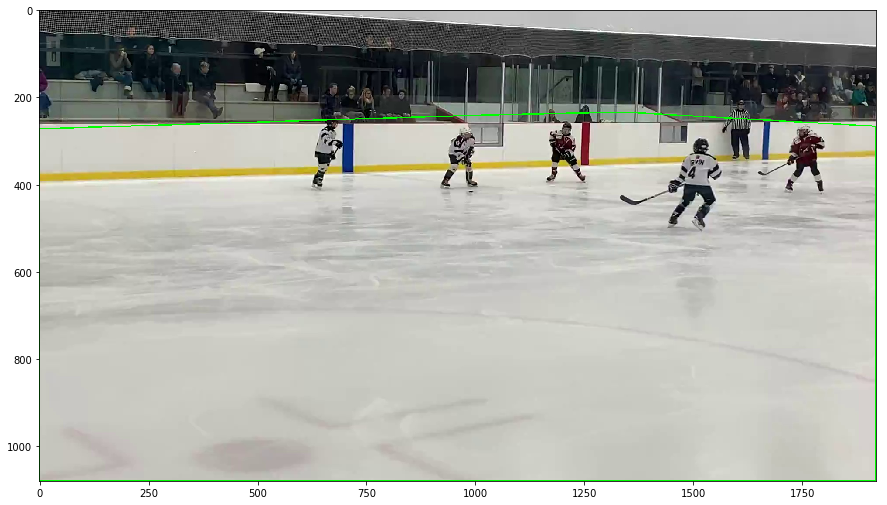

In [90]:
hull = convex_hull(p4)
img_with_hull = img.copy()
cv2.drawContours(img_with_hull, [hull], -1, (0, 255, 0), 2) 
plot_color(img_with_hull, (15, 15))

Just exploring some random stuff

In [13]:
yellow = np.zeros(shape=img.shape)
yellow[:] = np.array([0,0,255]) 


(1080, 1920)


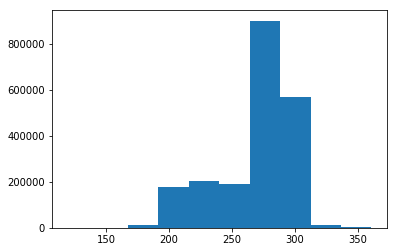

In [14]:
sqdist= np.sum((yellow - img)**2, axis=2)**(1/2)
print(sqdist.shape)
plt.hist(sqdist.ravel())
thresh = 255
sqdist[sqdist < thresh] = 1
sqdist[sqdist >= thresh] = 0

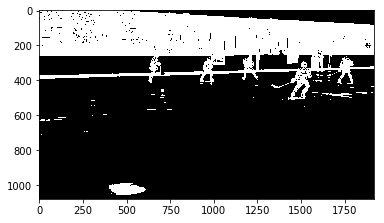

In [24]:
plt.imshow(sqdist, cmap='gray')


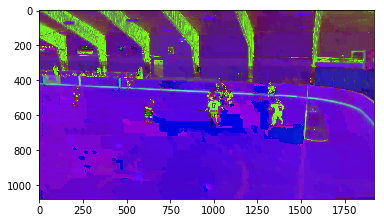

In [65]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.imshow(hsv)

177.33333333333334

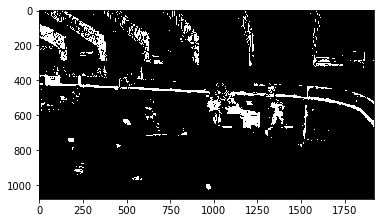

In [75]:
plt.imshow(np.mean(hsv, axis=2)>120, cmap='gray')
np.max(np.mean(hsv, axis=2))

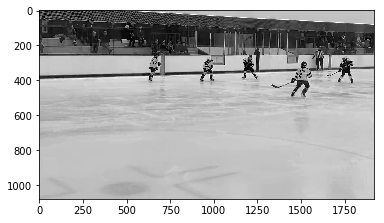

In [25]:
plt.imshow(img[:,:, 0], cmap='gray')

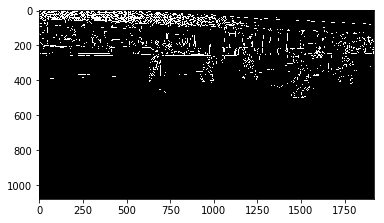

In [34]:
edges = cv2.Canny(img,10,255)
plot_gray(edges)

In [30]:
gauss = cv2.blur(sqdist, (29,29),cv2.BORDER_DEFAULT)
detected_circles = cv2.HoughCircles(gauss,  
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, 
               param2 = 30, minRadius = 100, maxRadius=200) 

error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\imgproc\src\hough.cpp:1736: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'cv::HoughCircles'


In [91]:
if detected_circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    detected_circles = np.uint16(np.around(detected_circles)) 
    copy = img.copy()
  
    for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
        # Draw the circumference of the circle. 
        cv2.circle(copy, (a, b), r, (0, 255, 0), 2) 
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(copy, (a, b), 1, (0, 0, 255), 3) 
        #cv2.imshow("Detected Circle", img) 
        #cv2.waitKey(0) 
#plot_color(copy, (15, 15))


# Part 2 Players detection

We will use YOLOv3 model to detect people in the image and we will filter the public.

In [172]:
import time
WHITE = (255, 255, 255)
cv = cv2
# Load names of classes and get random colors
classes = ['person']
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('models/yolov3.cfg', 'models/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# determine the output layer
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
def predict(img):
  
    
    blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

    net.setInput(blob)
    t0 = time.time()
    outputs = net.forward(ln)
    t = time.time() - t0

    # combine the 3 output groups into 1 (10647, 85)
    # large objects (507, 85)
    # medium objects (2028, 85)
    # small objects (8112, 85)
    outputs = np.vstack(outputs)
    return outputs

In [173]:
predictions = predict(img)

In [174]:
predictions.shape

(10647, 85)

In [214]:
def post_process(img, outputs, conf, hull):
    H, W = img.shape[:2]
    img = img.copy()
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        scores = output[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > conf:
            x, y, w, h = output[:4] * np.array([W, H, W, H])
            p0 = int(x - w//2), int(y - h//2)
            p1 = int(x + w//2), int(y + h//2)
            boxes.append([*p0, int(w), int(h)])
            confidences.append(float(confidence))
            classIDs.append(classID)
            # cv.rectangle(img, p0, p1, WHITE, 1)

    indices = cv.dnn.NMSBoxes(boxes, confidences, conf, conf-0.1)
    NMSBoxes = []
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            #filte
            if cv2.pointPolygonTest(hull, (x + w / 2, y + h / 2), False) >= 0:
                color = [int(c) for c in colors[classIDs[i]]]
                cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
                cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img, np.array(boxes)

In [217]:
img, boxes = post_process(img_with_hull, predictions, 0.4, hull)

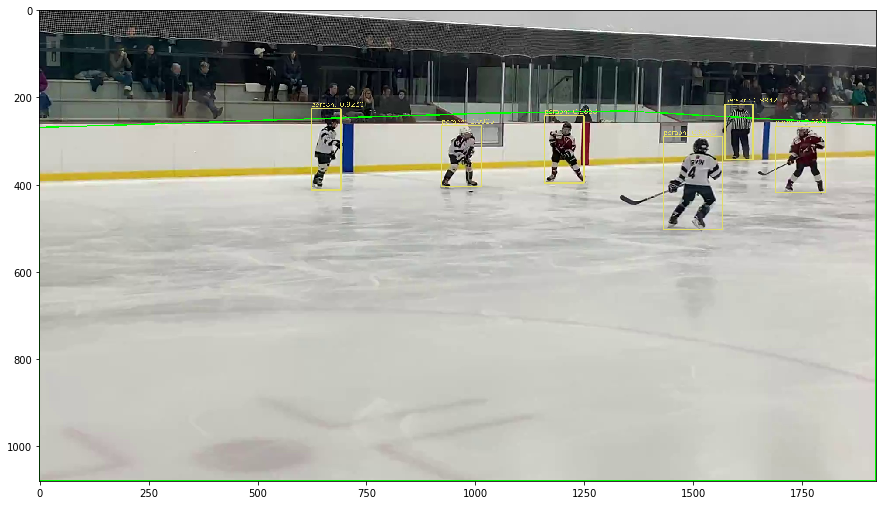

In [218]:
plot_color(img, (15,15))

Actually we could just have used the given players coordinates but YOLO :p

In [225]:
import pandas as pd

In [266]:
def parse_data(path):
    c = []
    data = pd.read_csv(path)
    for i in range(len(data)):
        players_coords = data.loc[i, 'players'].replace(',', '').replace('[','').replace(']','').split(' ')
        coords = np.array([int(string) for string in players_coords]).reshape(-1,2)
        #print(coords)
        #data.loc[i, 'players'] = coords
        c.append({
            'videoId': data.loc[i, 'videoId'],
            'frameId': data.loc[i, 'frameId'],
            'video': data.loc[i, 'video'],
            'image': data.loc[i, 'image'],
            'players': coords

        })
    return c

In [267]:
data = parse_data('dataset/players_coords.csv')

In [274]:
img_with_players = img_with_hull.copy()
for pos in data[0]['players']:
    cv2.circle(img_with_players, (pos[0], pos[1]), 20, [255,0,0])

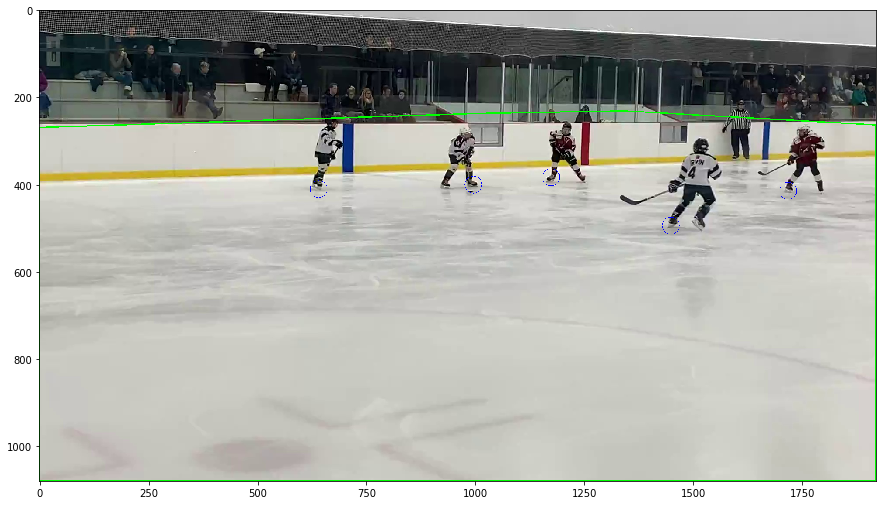

In [275]:
plot_color(img_with_players, (15,15))